In [101]:
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd

In [102]:
distribution_m = (4,1.2)
distribution_noise = (3,1.1)
distribution_experiment_noise = (0,1)
n_subjects = 20 # subjects
n_trials = int(100) # number of trials per subject
responses = (0.5,2)

In [103]:
results = {}
labels = {}
for n in range(n_subjects):
    # for each trial, there is internel noise contributes to the response
    internal_noise = np.random.normal(loc=distribution_noise[0],scale=distribution_noise[1],size=n_trials)
    # for each trial, there is a "m" drew from a N(4,1.2) distribution
    internal_m = np.random.normal(loc=distribution_m[0],scale=distribution_m[1],size=n_trials)
    # subject responses is a binomial distribution
    subject_responses = np.random.choice([-1,1],size=n_trials,p=[responses[0],responses[0]])
    # there exists some fixed experimental noise for all the subjects drew from a unit normal distribution
    noise = np.random.normal(loc=distribution_experiment_noise[0],scale=distribution_experiment_noise[1],size=n_trials)
    # since the formula: mx + b = y, where x is the measure, b is the internal noise, and y is the response,
    # the inverted measure simulation is: (y - b) / m + experimental noise
    measures = (subject_responses - internal_noise)/internal_m + noise
    results[n] = measures
    labels[n] = subject_responses

# fit a model for each subject and then plot the scores of them

In [104]:
from sklearn.model_selection import StratifiedKFold,cross_val_score

In [105]:
result_scores = []
for n in range(n_subjects):
    model = linear_model.LogisticRegression(class_weight='balanced',random_state=12345,max_iter=int(1e5))
    cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=12345)
    scores = cross_val_score(model,results[n].reshape(-1,1),labels[n],cv=cv,scoring='roc_auc',)
    result_scores.append(scores)
result_scores = np.array(result_scores)
result_scores = pd.DataFrame(np.array([result_scores.flatten(),np.repeat(np.arange(n_subjects),5)]).T,
                            columns=['scores','subjects'])
result_scores['subjects'] = result_scores['subjects'].astype(int)

In [106]:
result_scores.groupby(['subjects']).describe()

scores                                                              \
          count      mean       std       min       25%       50%       75%   
subjects                                                                      
0           5.0  0.650000  0.036056  0.600000  0.640000  0.650000  0.660000   
1           5.0  0.563596  0.162300  0.409091  0.460000  0.488889  0.660000   
2           5.0  0.711111  0.085292  0.595960  0.646465  0.747475  0.777778   
3           5.0  0.657172  0.143031  0.511111  0.515152  0.677778  0.745455   
4           5.0  0.446141  0.151034  0.281818  0.350000  0.388889  0.580000   
5           5.0  0.628872  0.217203  0.458333  0.462963  0.511364  0.768519   
6           5.0  0.678000  0.117558  0.520000  0.640000  0.640000  0.790000   
7           5.0  0.628283  0.049690  0.565657  0.595960  0.626263  0.666667   
8           5.0  0.546020  0.094183  0.418182  0.520000  0.536364  0.577778   
9           5.0  0.444000  0.105972  0.340000  0.350000  0.460000  0.470000   
10          5.0  0.718768  0.091461  0.572727  0.711111  0.730000  0.760000   
11          5.0  0.674000  0.059414  0.610000  0.630000  0.660000  0.720000   
12          5.0  0.675152  0.221614  0.300000  0.676768  0.722222  0.828283   
13          5.0  0.536768  0.059410  0.466667  0.500000  0.522222  0.585859   
14          5.0  0.714000  0.105972  0.650000  0.650000  0.670000  0.700000   
15          5.0  0.692727  0.108928  0.515152  0.676768  0.718182  0.755556   
16          5.0  0.720626  0.166088  0.509091  0.590000  0.755556  0.866667   
17          5.0  0.630101  0.132697  0.494949  0.505051  0.626263  0.733333   
18          5.0  0.569293  0.149970  0.427273  0.433333  0.533333  0.707071   
19          5.0  0.568889  0.154502  0.409091  0.490909  0.500000  0.644444   

                    
               max  
subjects            
0         0.700000  
1         0.800000  
2         0.787879  
3         0.836364  
4         0.630000  
5         0.943182  
6         0.800000  
7         0.686869  
8         0.677778  
9         0.600000  
10        0.820000  
11        0.750000  
12        0.848485  
13        0.609091  
14        0.900000  
15        0.797980  
16        0.881818  
17        0.790909  
18        0.745455  
19        0.800000

Text(0.5,1,'grand average AUC = 0.62')

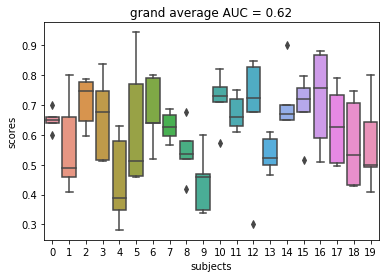

In [107]:
sns.boxplot(x='subjects',y='scores',data=result_scores)
plt.title('grand average AUC = %.2f'%(result_scores['scores'].mean()))

As we see from above, most of the subjects have a average AUC score above chance. Each subject has 5 model scores, which represent our estimate of the model mx + b = y. Thus, the grand average AUC (0.67) is how much the between-subject variability we estimate from the current simulated experiment.

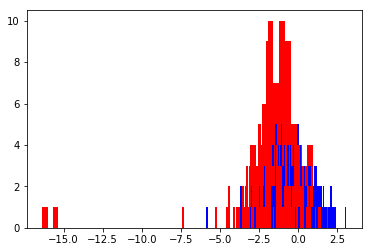

In [108]:
for (_,k),(_,l) in zip(results.items(),labels.items()): 
    idx_positive = l == 1
    idx_negative = l == -1
    plt.hist(k[idx_positive],color='blue',bins=50)
    plt.hist(k[idx_negative],color='red',bins=50)

As shown above, it the two distributions of measures for the positive responses (blue) and the negative responses (red). They overlap a lot, which suggests low signal-to-noise ratio for the data as a whole.

# average measures within each subject and fit a model for the averaged data

In [109]:
data = []
for (_,k),(_,l) in zip(results.items(),labels.items()):
    idx_positive = l == 1
    idx_negative = l == -1
    data.append([k[idx_positive].mean(),1])
    data.append([k[idx_negative].mean(),-1])
data = np.array(data)

In [110]:
model = linear_model.LogisticRegression(class_weight='balanced',random_state=12345,max_iter=int(1e5))
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=12345)
scores = cross_val_score(model,data[:,0].reshape(-1,1),data[:,1],cv=cv,scoring='roc_auc',)
print(scores)

[1.     1.     1.     0.9375 1.    ]


We have a perfect score when we use the averaged measures

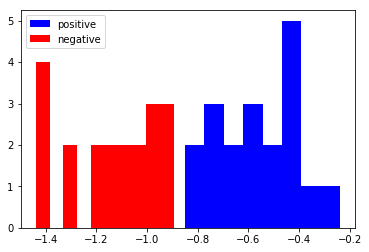

In [111]:
plt.hist(data[data[:,1]==1,0],color='blue',label='positive')
plt.hist(data[data[:,1]==-1,0],color='red',label='negative')
plt.legend()

As shown above, after we average the measure within each subject, we do have better representation (signal) of the data distribution. There is a clear boundary between positive and negative responses. 

# concatenate all the subjects but don't average over trials. Carefully cross validation

In [112]:
model = linear_model.LogisticRegression(class_weight='balanced',random_state=12345,max_iter=int(1e5))
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=12345)
data = []
for n,measure_ in results.items():
    temp = pd.Series(measure_)
    temp = temp.to_frame()
    temp['subject'] = n
    temp['label'] = labels[n]
    temp.columns = ['measures','subject','label']
    data.append(temp)
data = pd.concat(data)

In [113]:
scores = cross_val_score(model,data['measures'].values.reshape(-1,1),data['label'],
                         groups=data['subject'],# this parameter controls the split by subject not the labels
                         scoring='roc_auc',cv=cv,
                        )
print(scores,'average = %.2f'%(np.mean(scores)))

[0.62526745 0.66935363 0.59995999 0.62929085 0.63665377] average = 0.63


As shown above, the average score is similar to method 1